This notebook focuses on trying to find a way to segment cells within organoids properly.
The end goals is to segment cell and extract morphology features from cellprofiler.
These masks must be imported into cellprofiler to extract features.

In [ ]:
import argparse
import pathlib
import sys

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile
import torch
from cellpose import models
from skimage import io

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False


# Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

sys.path.append(f"{root_dir}/utils/")

from parsable_args import parse_segmentation_args

In [2]:
def segment_with_diameter(
    img: np.ndarray,
    model: models.Cellpose,
    diameter: int,
    z_axis: int = 0,
    channels: tuple = [1, 0],
    min_diameter: int = 200,  # in pixels, default is 250
    diameter_step: int = 200,
) -> tuple:
    """
    Recursively perform segmentation, stepping down through diameters by 200
    until a valid label is found or the minimum diameter is reached.
    This effectively performs a dynamic search for the largest detectable object
    in the image.

    Parameters
    ----------
    img : np.ndarray
        The image to segment. Can be 3D in the format of (z, y, x).
    model : models.Cellpose
        The Cellpose model to use for segmentation.
    diameter : int
        The diameter to use for segmentation.
        This is where the search starts.
    z_axis : int, optional
        The axis of the z-stack. Default is axis 0.
    channels : tuple, optional
        The channels to use for segmentation. Default is (1, 0).
        Where 1 is the channel for the cytoplasm and 0 using no other channel.
    min_diameter : int, optional
        The minimum diameter to use for segmentation.
        If the diameter is less than this, the function will return empty labels.
        Default is 200 pixels.
    diameter_step : int, optional
        The step size to decrease the diameter by when no labels are found.
        Default is 200 pixels.

    Returns
    -------
    tuple
        labels : np.ndarray
            The labels of the segmented image.
        details : dict
            The details of the segmentation.
        _ : None
            Placeholder for additional return values.
    """
    if diameter < min_diameter:
        print("Minimum diameter reached. Returning empty labels.")
        zero_labels = np.zeros_like(img)
        return zero_labels, None, None

    labels, details, _ = model.eval(
        img, channels=channels, z_axis=z_axis, diameter=diameter
    )

    if labels is None:
        print(f"Labels are empty for diameter {diameter}. Trying smaller diameter...")
        return segment_with_diameter(
            img, model, channels, z_axis, diameter - diameter_step
        )

    return labels, details, _


# test the function with three cylinders each with a different diameter
def test_segment_with_diameter():
    diameters = [100, 250, 400, 600, 800, 1000]
    z_depth = 1  # No z-depth for 2D images
    for diameter in diameters:
        img = np.zeros((1500, 1500), dtype=np.uint8)
        rr, cc = skimage.draw.disk((500, 500), diameter / 2)
        img[rr, cc] = 255

        labels, details, _ = segment_with_diameter(
            img,
            model=models.CellposeModel(gpu=use_GPU, model_type="cyto3"),
            diameter=diameter,
            z_axis=z_depth,
            channels=(1, 0),
        )
        # 100 should return empty labels
        if diameter == 100:
            assert np.all(labels == 0), (
                f"Labels should be empty for diameter {diameter}"
            )
        else:
            assert np.any(labels > 0), (
                f"Labels should not be empty for diameter {diameter}"
            )


if in_notebook:
    # If running in a notebook, run the test
    test_segment_with_diameter()

Minimum diameter reached. Returning empty labels.


In [ ]:
if not in_notebook:
    args_dict = parse_segmentation_args()
    patient = args_dict["patient"]
    well_fov = args_dict["well_fov"]
    clip_limit = args_dict["clip_limit"]
    twoD_method = args_dict["twoD_method"]
else:
    print("Running in a notebook")
    patient = "NF0014"
    well_fov = "C2-2"
    clip_limit = 0.01
    twoD_method = "zmax"

if twoD_method == "middle":
    input_dir = pathlib.Path(
        f"{root_dir}/data/{patient}/middle_slice_illum_correction/{well_fov}"
    ).resolve(strict=True)

elif twoD_method == "zmax":
    input_dir = pathlib.Path(
        f"{root_dir}/data/{patient}/zmax_proj_illum_correction/{well_fov}"
    ).resolve(strict=True)
else:
    raise ValueError(f"Unknown twoD_method: {twoD_method}")

mask_path = input_dir

## Set up images, paths and functions

In [4]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [5]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        pass
    elif "488" in f:
        pass
    elif "555" in f:
        cyto = io.imread(f)
    elif "640" in f:
        pass
    elif "TRANS" in f:
        pass
    elif "mask" in f:
        pass
    else:
        print(f"Unknown channel: {f}")

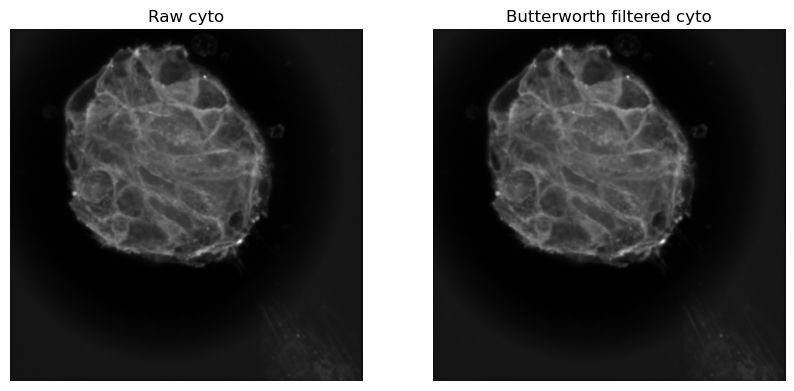

In [6]:
# # Use butterworth FFT filter to remove high frequency noise :)
cyto = skimage.filters.butterworth(
    cyto,
    cutoff_frequency_ratio=0.05,
    high_pass=False,
    order=1,
    squared_butterworth=True,
)

# add a guassian blur to the image
imgs = skimage.filters.gaussian(cyto, sigma=1)
if in_notebook:
    # plot the nuclei and the cyto channels
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto, cmap="gray")
    plt.title("Raw cyto")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(imgs, cmap="gray")
    plt.title("Butterworth filtered cyto")
    plt.axis("off")
    plt.show()

In [7]:
use_GPU = torch.cuda.is_available()
# Load the model
model_name = "cyto3"
model = models.CellposeModel(gpu=use_GPU, model_type=model_name)


# Perform segmentation of whole organoids with initial diameter of 750
labels, details, _ = segment_with_diameter(
    cyto,
    model=model,
    channels=[1, 0],
    z_axis=0,
    diameter=1000,  # initial diameter in pixels
    min_diameter=200,  # in pixels, default is 250
    diameter_step=200,  # in pixels, default is 200
)
# Save the labels
labels_path = input_dir / f"{well_fov}_organoid_masks.tiff"
tifffile.imwrite(labels_path, labels.astype(np.uint16))

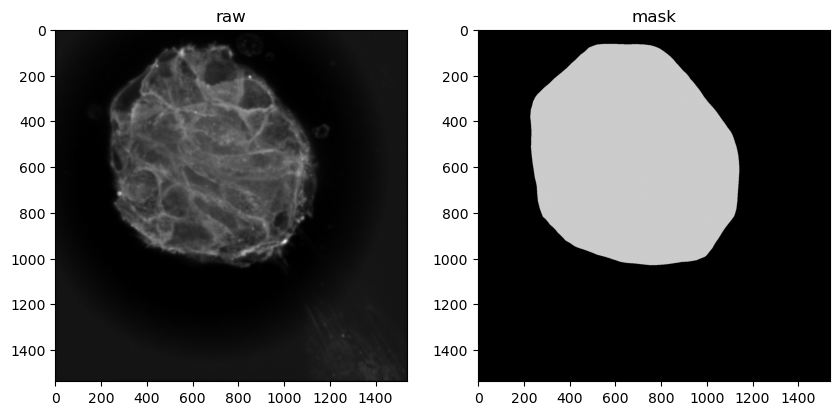

In [8]:
if in_notebook:
    plt.figure(figsize=(10, 10))
    plt.subplot(121)
    plt.imshow(cyto, cmap="gray")
    plt.title("raw")
    plt.subplot(122)
    plt.imshow(labels, cmap="nipy_spectral")
    plt.title("mask")
    plt.show()